# Regression using Pytorch

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from source.ffnn_model import WellLogFFNN
from source.ffnn_well_data_preprocessing import load_log_data

# Reproducibility, gotten from project 2
NP_RANDOM_SEED = 42
torch.manual_seed(NP_RANDOM_SEED)
np.random.seed(NP_RANDOM_SEED)


In [2]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(
    None,
    split_method="depth",
    gap=0
)

print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:",   X_val.shape)
print("X_test:",  X_test.shape)



[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Shapes:
X_train: torch.Size([8699, 11])
y_train: torch.Size([8699, 1])
X_val: torch.Size([1864, 11])
X_test: torch.Size([1865, 11])


In [3]:
# Basic statistics of y_train
print("y_train min:", y_train.min().item())
print("y_train max:", y_train.max().item())
print("y_train mean:", y_train.mean().item())
print("y_train std:", y_train.std().item())


y_train min: -2.958949327468872
y_train max: 3.607844352722168
y_train mean: -4.604474135305736e-09
y_train std: 1.0000574588775635


In [4]:
"""

Defining model and training function.

The model is a feedforward neural network defined in source/ffnn_model.py.

The training function uses MSE loss and Adam optimizer.

Code is adapted from project 2 part c.

"""

input_dim = X_train.shape[1]

# Defining model
def make_model(hidden_dims=(64, 64), dropout=0.2, activation=nn.ReLU):
    return WellLogFFNN(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        dropout=dropout,
        activation=activation,
    )
# Training function
def train_model(
    model,
    X_train, y_train,
    X_val,   y_val,
    lr: float = 1e-3,
    epochs: int = 100,
    verbose: bool = False,
):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    best_state_dict = None

    train_losses = []
    val_losses   = []

    for epoch in range(epochs):
        # ---- TRAIN ----
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # ---- VALIDATION ----
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()

        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:4d} | Train MSE: {loss.item():.4f} | Val MSE: {val_loss:.4f}")

    # last best weights
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    return model, best_val_loss, train_losses, val_losses


In [5]:
# Training with different configurations and evaluating on test set
configs = [
    {"name": "small_no_dropout",  "hidden_dims": (32, 32),        "lr": 1e-3, "dropout": 0.0},
    {"name": "medium_dropout",    "hidden_dims": (64, 64),        "lr": 1e-3, "dropout": 0.2},
    {"name": "deep_dropout",      "hidden_dims": (128, 64, 32),   "lr": 1e-4, "dropout": 0.2},
    {"name": "medium_lr_high",    "hidden_dims": (64, 64),        "lr": 1e-2, "dropout": 0.2},
]

results = []
histories = {}

for cfg in configs:
    print(f"\n=== Training config: {cfg['name']} ===")
    print(f"hidden_dims={cfg['hidden_dims']}, lr={cfg['lr']}, dropout={cfg['dropout']}")

    torch.manual_seed(NP_RANDOM_SEED)
    np.random.seed(NP_RANDOM_SEED)

    model = make_model(
        hidden_dims=cfg["hidden_dims"],
        dropout=cfg["dropout"],
        activation=nn.ReLU,
    )

    model, best_val_mse, train_losses, val_losses = train_model(
        model,
        X_train, y_train,
        X_val,   y_val,
        lr=cfg["lr"],
        epochs=100,
        verbose=False,
    )

    # evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
        test_mse = nn.MSELoss()(y_pred_test, y_test).item()

    results.append({
        "name":        cfg["name"],
        "hidden_dims": cfg["hidden_dims"],
        "lr":          cfg["lr"],
        "dropout":     cfg["dropout"],
        "val_mse":     best_val_mse,
        "test_mse":    test_mse,
    })

    histories[cfg["name"]] = {
        "train_losses": train_losses,
        "val_losses":   val_losses,
    }

results_df = pd.DataFrame(results)
display(results_df)



=== Training config: small_no_dropout ===
hidden_dims=(32, 32), lr=0.001, dropout=0.0

=== Training config: medium_dropout ===
hidden_dims=(64, 64), lr=0.001, dropout=0.2

=== Training config: deep_dropout ===
hidden_dims=(128, 64, 32), lr=0.0001, dropout=0.2

=== Training config: medium_lr_high ===
hidden_dims=(64, 64), lr=0.01, dropout=0.2


,name,hidden_dims,lr,dropout,val_mse,test_mse
0,small_no_dropout,"(32, 32)",0.0010,0.0,0.753166,6.809186
1,medium_dropout,"(64, 64)",0.0010,0.2,0.871950,7.968130
2,deep_dropout,"(128, 64, 32)",0.0001,0.2,1.419740,9.074826
3,medium_lr_high,"(64, 64)",0.0100,0.2,0.829515,8.020750


In [6]:
import optuna
from optuna.trial import Trial  

"""Objective function for Optuna hyperparameter optimization."""

# Define objective function for Optuna
def objective(trial):
    (X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(
        random_state=42, split_method="depth", gap=0
    )    
    
    
    # Suggest hyperparameters
    hidden_dim1 = trial.suggest_int("hidden_dim1", 16, 256, step=16)
    hidden_dim2 = trial.suggest_int("hidden_dim2", 16, 256, step=16)
    hidden_dim3 = trial.suggest_int("hidden_dim3", 16, 256, step=16)
    n_layers = trial.suggest_int("n_layers", 2, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    
    # Build hidden_dims tuple based on n_layers
    hidden_dims_list = [hidden_dim1, hidden_dim2, hidden_dim3][:n_layers]
    hidden_dims = tuple(hidden_dims_list)
    
    # Reset seeds for reproducibility
    torch.manual_seed(NP_RANDOM_SEED)
    np.random.seed(NP_RANDOM_SEED)
    
    # Create and train model
    model = make_model(
        hidden_dims=hidden_dims,
        dropout=dropout, 
        activation=nn.ReLU,
    )
    
    model, best_val_mse, _, _ = train_model(
        model,
        X_train, y_train,
        X_val, y_val,
        lr=lr,
        epochs=100,
        verbose=False,
    )
    
    return best_val_mse

# Create and run Optuna study
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(
    study_name="ffnn_regression_rs42_new",
    storage="sqlite:///optuna_study.db",
    direction="minimize",
    load_if_exists=False,
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

# Get best trial
best_trial = study.best_trial

print("\n" + "="*60)
print("OPTUNA OPTIMIZATION RESULTS")
print("="*60)
print(f"Best validation MSE: {best_trial.value:.6f}")
print("\nBest hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")
print("="*60)


/workspaces/project3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting Optuna hyperparameter optimization...


[I 2025-12-17 12:04:59,078] A new study created in RDB with name: ffnn_regression_rs42_new
  0%|          | 0/50 [00:00<?, ?it/s]

[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 0. Best value: 0.785911:   2%|▏         | 1/50 [00:07<06:16,  7.68s/it]

[I 2025-12-17 12:05:06,757] Trial 0 finished with value: 0.785910964012146 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 144, 'hidden_dim3': 16, 'n_layers': 4, 'dropout': 0.2, 'lr': 0.0026745526846759277}. Best is trial 0 with value: 0.785910964012146.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 0. Best value: 0.785911:   4%|▍         | 2/50 [00:17<07:18,  9.14s/it]

[I 2025-12-17 12:05:16,918] Trial 1 finished with value: 1.5132851600646973 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 208, 'hidden_dim3': 64, 'n_layers': 4, 'dropout': 0.1, 'lr': 2.7137383417758563e-05}. Best is trial 0 with value: 0.785910964012146.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 0. Best value: 0.785911:   6%|▌         | 3/50 [00:33<09:38, 12.30s/it]

[I 2025-12-17 12:05:32,977] Trial 2 finished with value: 1.239678144454956 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 224, 'hidden_dim3': 240, 'n_layers': 3, 'dropout': 0.30000000000000004, 'lr': 6.262347165043048e-05}. Best is trial 0 with value: 0.785910964012146.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 0. Best value: 0.785911:   8%|▊         | 4/50 [00:42<08:23, 10.95s/it]

[I 2025-12-17 12:05:41,847] Trial 3 finished with value: 1.3642140626907349 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 128, 'hidden_dim3': 32, 'n_layers': 2, 'dropout': 0.4, 'lr': 3.56659604280568e-05}. Best is trial 0 with value: 0.785910964012146.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 0. Best value: 0.785911:  10%|█         | 5/50 [00:45<06:04,  8.09s/it]

[I 2025-12-17 12:05:44,881] Trial 4 finished with value: 1.014753818511963 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 64, 'hidden_dim3': 208, 'n_layers': 2, 'dropout': 0.4, 'lr': 0.0017208923233435409}. Best is trial 0 with value: 0.785910964012146.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 0. Best value: 0.785911:  12%|█▏        | 6/50 [00:49<04:52,  6.65s/it]

[I 2025-12-17 12:05:48,742] Trial 5 finished with value: 1.7043871879577637 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 32, 'hidden_dim3': 32, 'n_layers': 4, 'dropout': 0.30000000000000004, 'lr': 1.0229197913597139e-05}. Best is trial 0 with value: 0.785910964012146.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 0. Best value: 0.785911:  14%|█▍        | 7/50 [00:52<03:48,  5.32s/it]

[I 2025-12-17 12:05:51,328] Trial 6 finished with value: 1.1343477964401245 and parameters: {'hidden_dim1': 80, 'hidden_dim2': 32, 'hidden_dim3': 128, 'n_layers': 2, 'dropout': 0.4, 'lr': 0.0002031532462744952}. Best is trial 0 with value: 0.785910964012146.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 0. Best value: 0.785911:  16%|█▌        | 8/50 [00:58<03:51,  5.52s/it]

[I 2025-12-17 12:05:57,258] Trial 7 finished with value: 0.8926829695701599 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 208, 'hidden_dim3': 96, 'n_layers': 2, 'dropout': 0.4, 'lr': 0.0005704680274623992}. Best is trial 0 with value: 0.785910964012146.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.66712:  18%|█▊        | 9/50 [01:08<04:52,  7.15s/it] 

[I 2025-12-17 12:06:07,983] Trial 8 finished with value: 0.667119562625885 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 256, 'hidden_dim3': 80, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.00437581454363842}. Best is trial 8 with value: 0.667119562625885.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.66712:  20%|██        | 10/50 [01:19<05:32,  8.30s/it]

[I 2025-12-17 12:06:18,880] Trial 9 finished with value: 0.7251163125038147 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 208, 'hidden_dim3': 112, 'n_layers': 2, 'dropout': 0.4, 'lr': 0.0009640881857087099}. Best is trial 8 with value: 0.667119562625885.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.66712:  22%|██▏       | 11/50 [01:26<05:08,  7.90s/it]

[I 2025-12-17 12:06:25,868] Trial 10 finished with value: 0.7154232859611511 and parameters: {'hidden_dim1': 144, 'hidden_dim2': 256, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.005197340709832928}. Best is trial 8 with value: 0.667119562625885.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.66712:  24%|██▍       | 12/50 [01:33<04:50,  7.65s/it]

[I 2025-12-17 12:06:32,942] Trial 11 finished with value: 0.775653600692749 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 256, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.006953921826423926}. Best is trial 8 with value: 0.667119562625885.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.66712:  26%|██▌       | 13/50 [01:39<04:19,  7.00s/it]

[I 2025-12-17 12:06:38,462] Trial 12 finished with value: 0.8189777135848999 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 256, 'hidden_dim3': 160, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.008953473647157924}. Best is trial 8 with value: 0.667119562625885.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.66712:  28%|██▊       | 14/50 [01:46<04:14,  7.07s/it]

[I 2025-12-17 12:06:45,673] Trial 13 finished with value: 0.7339851260185242 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 160, 'hidden_dim3': 80, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.0032896493053136714}. Best is trial 8 with value: 0.667119562625885.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.66712:  30%|███       | 15/50 [01:52<03:59,  6.85s/it]

[I 2025-12-17 12:06:52,016] Trial 14 finished with value: 1.0875598192214966 and parameters: {'hidden_dim1': 16, 'hidden_dim2': 176, 'hidden_dim3': 160, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.00022437582371519002}. Best is trial 8 with value: 0.667119562625885.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 8. Best value: 0.66712:  32%|███▏      | 16/50 [02:00<04:02,  7.13s/it]

[I 2025-12-17 12:06:59,788] Trial 15 finished with value: 0.6983460783958435 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 256, 'hidden_dim3': 256, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0045260272291029165}. Best is trial 8 with value: 0.667119562625885.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  34%|███▍      | 17/50 [02:10<04:18,  7.82s/it]

[I 2025-12-17 12:07:09,231] Trial 16 finished with value: 0.6317777037620544 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 96, 'hidden_dim3': 240, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.001356667603019955}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  36%|███▌      | 18/50 [02:20<04:30,  8.46s/it]

[I 2025-12-17 12:07:19,188] Trial 17 finished with value: 0.7407932281494141 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 112, 'hidden_dim3': 224, 'n_layers': 4, 'dropout': 0.2, 'lr': 0.0011484958169732944}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  38%|███▊      | 19/50 [02:27<04:14,  8.22s/it]

[I 2025-12-17 12:07:26,838] Trial 18 finished with value: 0.8696115016937256 and parameters: {'hidden_dim1': 96, 'hidden_dim2': 96, 'hidden_dim3': 208, 'n_layers': 4, 'dropout': 0.2, 'lr': 0.0005735259844407737}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  40%|████      | 20/50 [02:36<04:14,  8.49s/it]

[I 2025-12-17 12:07:35,967] Trial 19 finished with value: 0.9141037464141846 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 80, 'hidden_dim3': 64, 'n_layers': 3, 'dropout': 0.5, 'lr': 0.0019357248547447958}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  42%|████▏     | 21/50 [02:46<04:16,  8.83s/it]

[I 2025-12-17 12:07:45,587] Trial 20 finished with value: 0.703265905380249 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 176, 'hidden_dim3': 128, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.0005695600170381402}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  44%|████▍     | 22/50 [02:53<03:53,  8.34s/it]

[I 2025-12-17 12:07:52,768] Trial 21 finished with value: 0.7497665882110596 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 224, 'hidden_dim3': 256, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.004832827382911226}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  46%|████▌     | 23/50 [03:02<03:45,  8.35s/it]

[I 2025-12-17 12:08:01,166] Trial 22 finished with value: 0.8395713567733765 and parameters: {'hidden_dim1': 112, 'hidden_dim2': 64, 'hidden_dim3': 256, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.0034668830685903244}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  48%|████▊     | 24/50 [03:15<04:19,  9.99s/it]

[I 2025-12-17 12:08:14,961] Trial 23 finished with value: 0.681284487247467 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 240, 'hidden_dim3': 224, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.009732608740658129}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  50%|█████     | 25/50 [03:28<04:30, 10.83s/it]

[I 2025-12-17 12:08:27,749] Trial 24 finished with value: 0.753795325756073 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 224, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.008378526051287439}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  52%|█████▏    | 26/50 [03:40<04:25, 11.05s/it]

[I 2025-12-17 12:08:39,323] Trial 25 finished with value: 0.7457793354988098 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 112, 'hidden_dim3': 224, 'n_layers': 3, 'dropout': 0.30000000000000004, 'lr': 0.0015783955421663101}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  54%|█████▍    | 27/50 [03:51<04:17, 11.21s/it]

[I 2025-12-17 12:08:50,890] Trial 26 finished with value: 0.6407046318054199 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 176, 'hidden_dim3': 192, 'n_layers': 4, 'dropout': 0.2, 'lr': 0.002322607448519805}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  56%|█████▌    | 28/50 [04:04<04:15, 11.59s/it]

[I 2025-12-17 12:09:03,388] Trial 27 finished with value: 0.7608607411384583 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 176, 'hidden_dim3': 192, 'n_layers': 4, 'dropout': 0.30000000000000004, 'lr': 0.0008611192374700614}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  58%|█████▊    | 29/50 [04:12<03:42, 10.60s/it]

[I 2025-12-17 12:09:11,684] Trial 28 finished with value: 0.7989184856414795 and parameters: {'hidden_dim1': 144, 'hidden_dim2': 144, 'hidden_dim3': 144, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.0018600015936933566}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  60%|██████    | 30/50 [04:20<03:17,  9.88s/it]

[I 2025-12-17 12:09:19,876] Trial 29 finished with value: 0.8455493450164795 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 128, 'hidden_dim3': 96, 'n_layers': 4, 'dropout': 0.2, 'lr': 0.0025927200769243924}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  62%|██████▏   | 31/50 [04:33<03:21, 10.62s/it]

[I 2025-12-17 12:09:32,231] Trial 30 finished with value: 0.6841312050819397 and parameters: {'hidden_dim1': 240, 'hidden_dim2': 160, 'hidden_dim3': 192, 'n_layers': 4, 'dropout': 0.2, 'lr': 0.00035453477577653995}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  64%|██████▍   | 32/50 [04:48<03:38, 12.12s/it]

[I 2025-12-17 12:09:47,857] Trial 31 finished with value: 0.7204583287239075 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 240, 'hidden_dim3': 240, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.002706496559059201}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  66%|██████▌   | 33/50 [05:01<03:31, 12.45s/it]

[I 2025-12-17 12:10:01,069] Trial 32 finished with value: 0.7405986785888672 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 192, 'hidden_dim3': 224, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.007069599962974032}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  68%|██████▊   | 34/50 [05:18<03:36, 13.52s/it]

[I 2025-12-17 12:10:17,086] Trial 33 finished with value: 0.7574210166931152 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 240, 'hidden_dim3': 240, 'n_layers': 3, 'dropout': 0.30000000000000004, 'lr': 0.004760857991061687}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  70%|███████   | 35/50 [05:27<03:03, 12.21s/it]

[I 2025-12-17 12:10:26,242] Trial 34 finished with value: 0.7817091345787048 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 240, 'hidden_dim3': 16, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.009684445161749239}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  72%|███████▏  | 36/50 [05:34<02:31, 10.80s/it]

[I 2025-12-17 12:10:33,743] Trial 35 finished with value: 0.6742555499076843 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 192, 'hidden_dim3': 192, 'n_layers': 2, 'dropout': 0.2, 'lr': 0.002445284285270104}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  74%|███████▍  | 37/50 [05:40<02:02,  9.43s/it]

[I 2025-12-17 12:10:39,998] Trial 36 finished with value: 0.7580180168151855 and parameters: {'hidden_dim1': 144, 'hidden_dim2': 192, 'hidden_dim3': 48, 'n_layers': 2, 'dropout': 0.1, 'lr': 0.0013493681209487307}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  76%|███████▌  | 38/50 [05:46<01:38,  8.20s/it]

[I 2025-12-17 12:10:45,305] Trial 37 finished with value: 1.4297428131103516 and parameters: {'hidden_dim1': 112, 'hidden_dim2': 144, 'hidden_dim3': 192, 'n_layers': 2, 'dropout': 0.30000000000000004, 'lr': 7.704911773049818e-05}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  78%|███████▊  | 39/50 [05:51<01:20,  7.27s/it]

[I 2025-12-17 12:10:50,426] Trial 38 finished with value: 0.8131026029586792 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 48, 'hidden_dim3': 144, 'n_layers': 2, 'dropout': 0.30000000000000004, 'lr': 0.0023940402353451787}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  80%|████████  | 40/50 [05:56<01:05,  6.52s/it]

[I 2025-12-17 12:10:55,174] Trial 39 finished with value: 0.823192834854126 and parameters: {'hidden_dim1': 240, 'hidden_dim2': 16, 'hidden_dim3': 176, 'n_layers': 2, 'dropout': 0.2, 'lr': 0.0007754220108483155}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  82%|████████▏ | 41/50 [06:02<00:58,  6.47s/it]

[I 2025-12-17 12:11:01,540] Trial 40 finished with value: 1.2828259468078613 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 112, 'hidden_dim3': 112, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.00012657002831621363}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  84%|████████▍ | 42/50 [06:10<00:55,  6.93s/it]

[I 2025-12-17 12:11:09,530] Trial 41 finished with value: 0.6694236397743225 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 192, 'hidden_dim3': 240, 'n_layers': 2, 'dropout': 0.2, 'lr': 0.003399931333885846}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  86%|████████▌ | 43/50 [06:18<00:50,  7.25s/it]

[I 2025-12-17 12:11:17,537] Trial 42 finished with value: 0.6934787631034851 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 208, 'hidden_dim3': 240, 'n_layers': 2, 'dropout': 0.2, 'lr': 0.003715456606680301}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  88%|████████▊ | 44/50 [06:26<00:44,  7.36s/it]

[I 2025-12-17 12:11:25,147] Trial 43 finished with value: 0.7379466891288757 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 192, 'hidden_dim3': 208, 'n_layers': 2, 'dropout': 0.2, 'lr': 0.002201474047386008}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  90%|█████████ | 45/50 [06:33<00:37,  7.49s/it]

[I 2025-12-17 12:11:32,943] Trial 44 finished with value: 0.8364022970199585 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 160, 'hidden_dim3': 160, 'n_layers': 2, 'dropout': 0.30000000000000004, 'lr': 0.005974998296992824}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  92%|█████████▏| 46/50 [06:43<00:32,  8.11s/it]

[I 2025-12-17 12:11:42,498] Trial 45 finished with value: 1.4740357398986816 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 208, 'hidden_dim3': 192, 'n_layers': 2, 'dropout': 0.2, 'lr': 1.8182340654789424e-05}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  94%|█████████▍| 47/50 [06:47<00:20,  6.96s/it]

[I 2025-12-17 12:11:46,774] Trial 46 finished with value: 0.7437195777893066 and parameters: {'hidden_dim1': 144, 'hidden_dim2': 96, 'hidden_dim3': 240, 'n_layers': 2, 'dropout': 0.1, 'lr': 0.003378841114836963}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  96%|█████████▌| 48/50 [06:55<00:14,  7.29s/it]

[I 2025-12-17 12:11:54,843] Trial 47 finished with value: 0.7448650598526001 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 192, 'hidden_dim3': 176, 'n_layers': 2, 'dropout': 0.30000000000000004, 'lr': 0.00124300239776417}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778:  98%|█████████▊| 49/50 [07:03<00:07,  7.55s/it]

[I 2025-12-17 12:12:03,004] Trial 48 finished with value: 0.7642415165901184 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 224, 'hidden_dim3': 80, 'n_layers': 2, 'dropout': 0.2, 'lr': 0.000347620764428369}. Best is trial 16 with value: 0.6317777037620544.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.631778: 100%|██████████| 50/50 [07:13<00:00,  8.68s/it]

[I 2025-12-17 12:12:12,898] Trial 49 finished with value: 0.7104107141494751 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 160, 'hidden_dim3': 208, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.001430073088921097}. Best is trial 16 with value: 0.6317777037620544.

OPTUNA OPTIMIZATION RESULTS
Best validation MSE: 0.631778

Best hyperparameters:
  hidden_dim1: 176
  hidden_dim2: 96
  hidden_dim3: 240
  n_layers: 3
  dropout: 0.2
  lr: 0.001356667603019955


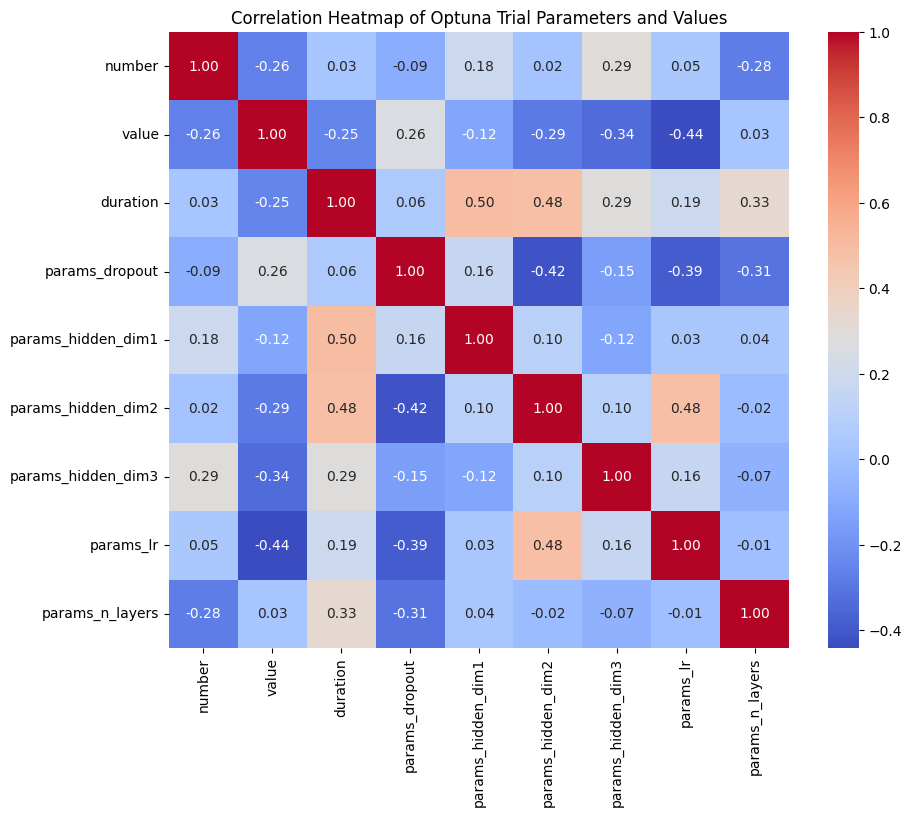

In [7]:
#plotting a heatmap of the optuna results
import seaborn as sns
import matplotlib.pyplot as plt

optuna_df = study.trials_dataframe()
plt.figure(figsize=(10, 8))
sns.heatmap(optuna_df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Optuna Trial Parameters and Values")
plt.show()

In [8]:
# === Extract best hyperparameters from Optuna ===
best_params = best_trial.params

# Build hidden layers tuple
n_layers = best_params["n_layers"]
best_hidden_dims = tuple([
    best_params["hidden_dim1"],
    best_params["hidden_dim2"],
    best_params["hidden_dim3"],
][:n_layers])

best_dropout = best_params["dropout"]
best_lr = best_params["lr"]

print("Using hidden_dims =", best_hidden_dims)
print("dropout =", best_dropout)
print("learning rate =", best_lr)


Using hidden_dims = (176, 96, 240)
dropout = 0.2
learning rate = 0.001356667603019955


Best config: small_no_dropout


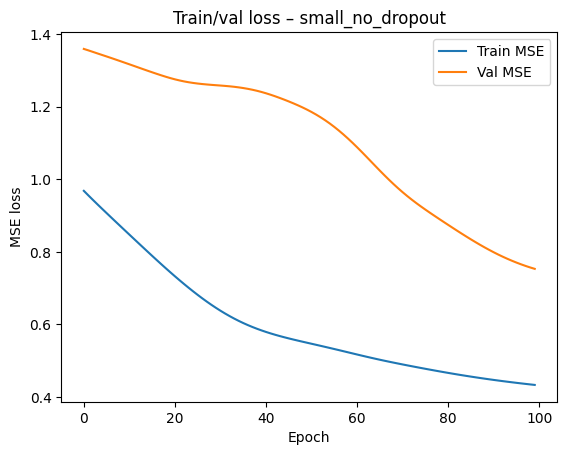

In [9]:
import matplotlib.pyplot as plt

y_pred_test_unscaled = y_scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_test_unscaled      = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting train/val loss curves for best config
best_name = results_df.sort_values("val_mse").iloc[0]["name"]
print("Best config:", best_name)

train_losses = histories[best_name]["train_losses"]
val_losses   = histories[best_name]["val_losses"]

plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses,   label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.title(f"Train/val loss – {best_name}")
plt.show()


Best Optuna params: {'hidden_dim1': 176, 'hidden_dim2': 96, 'hidden_dim3': 240, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.001356667603019955}
Using hidden_dims = (176, 96, 240) dropout = 0.2 lr = 0.001356667603019955


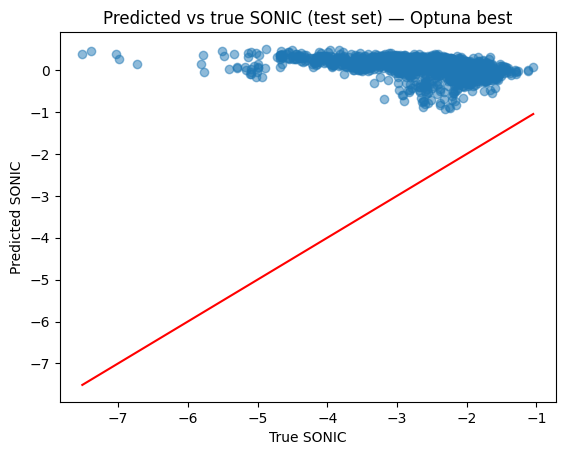

In [10]:
# Use Optuna best trial to rebuild & retrain the model, then plot preds vs true
params = best_trial.params
n_layers = params.get("n_layers", 2)
hidden_dims = tuple([params["hidden_dim1"], params["hidden_dim2"], params["hidden_dim3"]][:n_layers])
dropout = params.get("dropout", 0.0)
lr = params.get("lr", 1e-3)

print("Best Optuna params:", params)
print("Using hidden_dims =", hidden_dims, "dropout =", dropout, "lr =", lr)

# Reproducibility
torch.manual_seed(NP_RANDOM_SEED)
np.random.seed(NP_RANDOM_SEED)

# Build and train model using Optuna params
model = make_model(
    hidden_dims=hidden_dims,
    dropout=dropout,
    activation=nn.ReLU,
)
model, _, _, _ = train_model(
    model,
    X_train, y_train,
    X_val,   y_val,
    lr=lr,
    epochs=100,
    verbose=False,
)

# Predictions on test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).cpu().numpy()
y_true_test = y_test.cpu().numpy()

# Scatter plot
plt.figure()
plt.scatter(y_true_test, y_pred_test, alpha=0.5)
plt.xlabel("True SONIC")
plt.ylabel("Predicted SONIC")
plt.title("Predicted vs true SONIC (test set) — Optuna best")
plt.plot([y_true_test.min(), y_true_test.max()],
         [y_true_test.min(), y_true_test.max()], color="red")
plt.show()


[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 0: R² = 0.7730
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 1: R² = 0.7875
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 2: R² = 0.8056
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 3: R² = 0.8133
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 4: R² = 0.7875


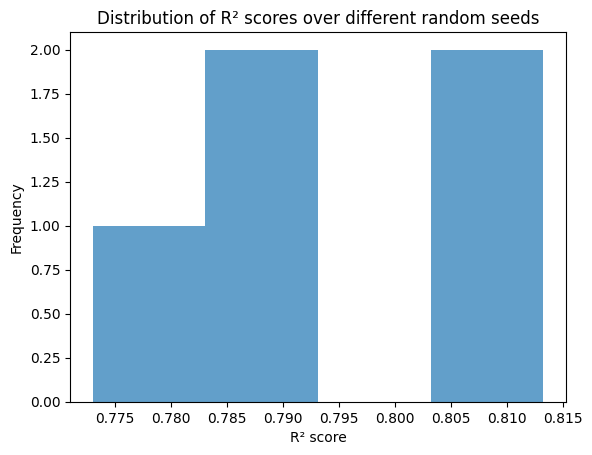

In [11]:
"""
Calculating R² score.
"""

from sklearn.metrics import r2_score

seeds = [0, 1, 2, 3, 4]
scores = []

for seed in seeds:
    # 1. new random split
    (X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(None)

    # 2. train model with same hyperparameters
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = make_model(  # use best params fra Optuna
        hidden_dims = hidden_dims,
        dropout = best_dropout,
        activation = nn.ReLU,
    )

    model, best_val_mse, train_losses, val_losses = train_model(
        model,
        X_train, y_train,
        X_val,   y_val,
        lr=best_lr,
        epochs=100,
        verbose=False,
    )

    # 3. evaluate on test
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)

    r2 = r2_score(
        y_test.numpy().ravel(),
        y_pred_test.numpy().ravel()
    )
    print(f"Seed {seed}: R² = {r2:.4f}")
    scores.append(r2)

print("R² scores:", scores)
print("Mean R²:", np.mean(scores))
print("Std  R²:", np.std(scores))

plt.figure()
plt.hist(scores, bins='auto', alpha=0.7)
plt.xlabel("R² score")
plt.ylabel("Frequency")
plt.title("Distribution of R² scores over different random seeds")
plt.show()



Ridge baseline:
Test MSE: 0.35399413108825684
Test R²: 0.653856635093689


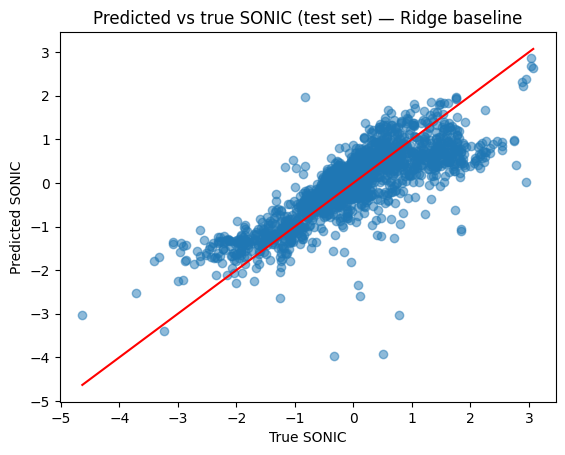

In [12]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Convert tensors to numpy
X_tr = X_train.numpy()
y_tr = y_train.numpy().ravel()
X_te = X_test.numpy()
y_te = y_test.numpy().ravel()

ridge = Ridge(alpha=1.0)
ridge.fit(X_tr, y_tr)

ridge_pred = ridge.predict(X_te)

ridge_mse = mean_squared_error(y_te, ridge_pred)
ridge_r2  = r2_score(y_te, ridge_pred)

print("Ridge baseline:")
print("Test MSE:", ridge_mse)
print("Test R²:", ridge_r2)

plt.figure()
plt.scatter(y_te, ridge_pred, alpha=0.5)
plt.xlabel("True SONIC")
plt.ylabel("Predicted SONIC")
plt.title("Predicted vs true SONIC (test set) — Ridge baseline")
plt.plot([y_te.min(), y_te.max()],
            [y_te.min(), y_te.max()], color="red")
plt.show()
